In [ ]:
# Install PyTorch (Colab usually already has it)
# !pip install torch torchvision

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transform: convert images to tensors and normalize 0–1 range
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download + Load training and test datasets
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Check sizes
print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


100%|██████████| 9.91M/9.91M [00:00<00:00, 58.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.71MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.76MB/s]

Training samples: 60000
Test samples: 10000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print("Training samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Training samples: 60000
Test samples: 10000


In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_size=128, num_classes=10, depth=1):
        super(MLP, self).__init__()

        layers = []

        # First hidden layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Extra hidden layers
        for _ in range(depth - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_size, num_classes))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.network(x)


In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, lr=0.001):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    train_losses = []
    test_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {train_losses[-1]:.4f} | Test Acc: {accuracy:.2f}%")

    return train_losses, test_accuracies


In [ ]:
model_1 = MLP(depth=1)
model_2 = MLP(depth=2)
model_4 = MLP(depth=4)


In [ ]:
print("Training MLP with depth = 1")
loss1, acc1 = train_model(model_1, train_loader, test_loader, epochs=5)

print("\nTraining MLP with depth = 2")
loss2, acc2 = train_model(model_2, train_loader, test_loader, epochs=5)

print("\nTraining MLP with depth = 4")
loss4, acc4 = train_model(model_4, train_loader, test_loader, epochs=5)


Training MLP with depth = 1
Epoch 1/5 | Loss: 0.0861 | Test Acc: 96.83%
Epoch 2/5 | Loss: 0.0762 | Test Acc: 97.06%
Epoch 3/5 | Loss: 0.0691 | Test Acc: 97.51%
Epoch 4/5 | Loss: 0.0617 | Test Acc: 97.34%
Epoch 5/5 | Loss: 0.0564 | Test Acc: 96.54%

Training MLP with depth = 2
Epoch 1/5 | Loss: 0.1176 | Test Acc: 96.47%
Epoch 2/5 | Loss: 0.0982 | Test Acc: 96.69%
Epoch 3/5 | Loss: 0.0817 | Test Acc: 96.83%
Epoch 4/5 | Loss: 0.0733 | Test Acc: 97.09%
Epoch 5/5 | Loss: 0.0644 | Test Acc: 97.42%

Training MLP with depth = 4
Epoch 1/5 | Loss: 0.4090 | Test Acc: 93.62%
Epoch 2/5 | Loss: 0.1792 | Test Acc: 95.25%
Epoch 3/5 | Loss: 0.1308 | Test Acc: 96.03%
Epoch 4/5 | Loss: 0.1135 | Test Acc: 96.76%
Epoch 5/5 | Loss: 0.0924 | Test Acc: 96.21%


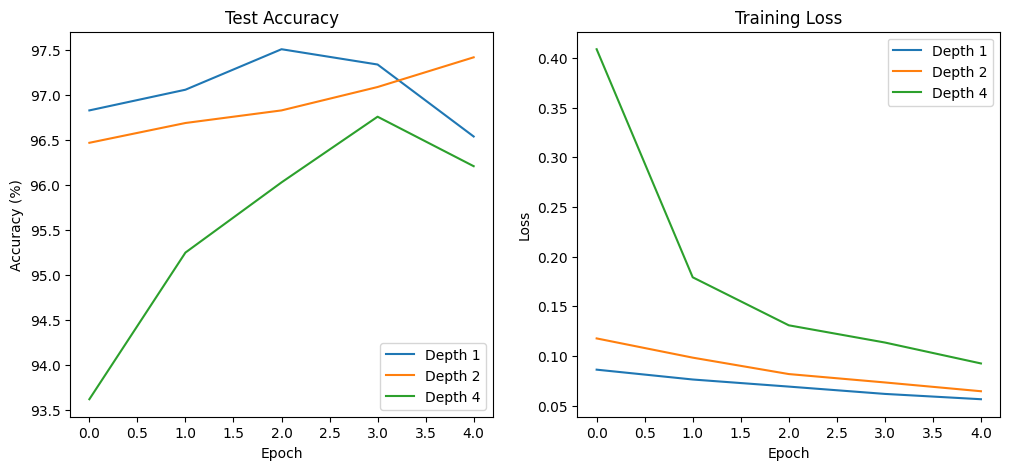

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(acc1, label="Depth 1")
plt.plot(acc2, label="Depth 2")
plt.plot(acc4, label="Depth 4")
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(loss1, label="Depth 1")
plt.plot(loss2, label="Depth 2")
plt.plot(loss4, label="Depth 4")
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Save figure as PNG
plt.savefig("accuracy_loss_plot.png", dpi=300, bbox_inches='tight')

plt.show()


Git Link:

https://github.com/Vivek9049P/MLP.git